In [1]:
import discretize as ds
import SimPEG.potential_fields as pf
from SimPEG import (
    maps, utils, simulation, inverse_problem, inversion, optimization, regularization, data_misfit, directives
)
import os
from SimPEG.utils import io_utils
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as cm
from matplotlib import rc
from glob import glob
from scipy.interpolate import NearestNDInterpolator

import seaborn
#seaborn.reset_orig()
#seaborn.set()
rc('text', usetex=True)

# Load models

In [2]:
mesh = ds.TreeMesh.readUBC('../Assets/mesh_CaMP.ubc')

### CHOOSE WHICH WEIGHTING

In [3]:
which_weights = 'FINAL_DepthWeighting' #'SensWeighting/'

In [4]:
true_mag_model = mesh.readModelUBC('../Assets/CaMP_magnetic_synthetic_model.ubc')
geology_model = true_mag_model.copy()
true_density_model = true_mag_model.copy()
geology_model[true_mag_model==0.05] = 1
geology_model[true_mag_model==.15] = 2
true_density_model[true_mag_model==0.05] = 0.1
true_density_model[true_mag_model==.15] = -0.2

In [5]:
gravity_l22 = mesh.read_model_UBC(glob('../L2/'+which_weights+'/*.den')[0])
gravity_lpq = mesh.read_model_UBC(glob('../Lpq/'+which_weights+'/*.den')[0])
gravity_pgi = np.load('../pgi-gravity/'+which_weights+'/pgi_gravity-singlephysics.npy')
gravity_jnt = np.load('../pgi-joint/'+which_weights+'/pgi_gravity_joint.npy')

magnetic_l22 = mesh.read_model_UBC(glob('../L2/'+which_weights+'/*.sus')[0])
magnetic_lpq = mesh.read_model_UBC(glob('../Lpq/'+which_weights+'/*.sus')[0])
magnetic_pgi = np.load('../pgi-magnetic/'+which_weights+'/pgi_magnetic-singlephysics.npy')
magnetic_jnt = np.load('../pgi-joint/'+which_weights+'/pgi_magnetic_joint.npy')

quasi_geology_gravity = np.load('../pgi-gravity/'+which_weights+'/pgi_quasigeology_gravity-singlephysics.npy')
quasi_geology_magnetic = np.load('../pgi-magnetic/'+which_weights+'/pgi_quasigeology_magnetic-singlephysics.npy')
quasi_geology_jnt = np.load('../pgi-joint/'+which_weights+'/pgi_quasigeology_joint.npy')

gmm_gravity = pickle.load(open('../pgi-gravity/'+which_weights+'/GMMRF-_gravity-singlephysics.p','rb'))
gmm_gravity.means_ += 2.9
gmm_magnetic = pickle.load(open('../pgi-magnetic/'+which_weights+'/GMMRF-_magnetic-singlephysics.p','rb'))
gmm_joint = pickle.load(open('../pgi-joint/'+which_weights+'/GMMRF_joint.p','rb'))
gmm_joint.means_[:,0] += 2.9

# Geophysical data

In [6]:
from scipy.constants import G

In [7]:
data_grav = io_utils.read_grav3d_ubc('../Assets/grav_data.obs')
data_mag = io_utils.read_mag3d_ubc('../Assets/magnetic_data.obs')


# plotting functions and parameters

In [8]:
norm_grav_data = cm.TwoSlopeNorm(vmax=(-data_grav.dobs).max(), vcenter=0, vmin=(-data_grav.dobs).min())
norm_mag_data = cm.TwoSlopeNorm(vmax=data_mag.dobs.max(), vcenter=0, vmin=data_mag.dobs.min())

In [9]:
titlesize = 28
labelsize = 24
ticksize = 22

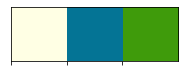

In [10]:
# create geology colorcode
colors = ["xkcd:off white", 'xkcd:sea blue', "#3f9b0b",] #,'#7CFC79', '#080A7F'
seaborn.palplot(colors)
geocmap = cm.ListedColormap(colors, name='from_list', N=None)

In [11]:
def plotting_model(
    ax,
    mesh,
    plot_model,
    clim,
    cmap,
    legend_cb,
    geology_model = geology_model,
    slicex=0.,
    slicey=0.,
    slicez= -750,
    plot_grid=False,
    is_geology=False,
    z_aspect=2.,
    title='',
    plot_cb=True,
    is_vector=False,
    is_spherical=True,
    quiver_opts = {'scale':0.2, 'scale_units':"inches"},
    titlesize = 20,
    labelsize = 18,
    ticksize = 16,
    meshplotOpts = {},
    
):
    if is_vector:
        if is_spherical:
            plot_model = utils.mat_utils.spherical2cartesian(
                plot_model.reshape((mesh.nC, 3), order="F")
            )
        plot_model = plot_model.reshape((len(mesh), 3), order='F')
        plotOpts = {'v_type':'CCv', 'view':'vec', 'quiver_opts':quiver_opts}
    else:
        plotOpts = {}
    
    ind_xy = int(np.where(mesh.vectorCCz == mesh.vectorCCz[np.abs(mesh.vectorCCz-slicez).argmin()])[0][0])
    ind_xz = int(np.where(mesh.vectorCCy == mesh.vectorCCy[np.abs(mesh.vectorCCy-slicey).argmin()])[0][0])
    ind_yz = int(np.where(mesh.vectorCCx == mesh.vectorCCx[np.abs(mesh.vectorCCx-slicex).argmin()])[0][0])

    indslicezplot = mesh.gridCC[:,2] == mesh.vectorCCz[ind_xy]
    indsliceyplot = mesh.gridCC[:,1] == mesh.vectorCCy[ind_xz]
    indslicexplot = mesh.gridCC[:,0] == mesh.vectorCCx[ind_yz]
    
    #plot true model
    for j, (plane, indd) in enumerate(zip([[0,1],[0,2],], [indslicezplot, indsliceyplot,])):
        _, _, CS = utils.plot2Ddata(
            mesh.gridCC[indd][:,plane],geology_model[indd],nx=200,ny=200,
            clim=[0,2],
             contourOpts={'alpha':0},
             ax=ax[j],
             level=True,
             ncontour=2,
             levelOpts={
                 'colors':'k','linewidths':2,#'linestyles':'dotted', 
                 #'label':'True geology contour'
             },
            method='nearest'
        )   
        CS.collections[0].set_label('True geology model (contours)')
    #PLAN MAP
    mm = mesh.plotSlice(
        plot_model,normal='Z', ind=ind_xy, clim=clim,
        grid=plot_grid,pcolorOpts={'cmap':cmap,**meshplotOpts},
        ax=ax[0],
        **plotOpts,
    )
    ax[0].set_xlabel('')#'X (m)', fontsize=18)
    ax[0].set_ylabel('Y (m)', fontsize=labelsize)
    
    ax[0].plot(
        [-16000,16000],np.ones(2)*mesh.vectorCCy[ind_xz],
        linestyle='dashed',linewidth=3,c='xkcd:dark gray', 
        label='cross-section location'
    )
    ax[0].legend(fontsize=labelsize)
    ax[0].set_yticks(np.linspace(-15000,15000,7))
    ax[0].set_yticklabels(
        ['${}$'.format(lbl) for lbl in np.linspace(-15000,15000,7,dtype='int')], 
        va='center', ha='center'
    )
    ax[0].set_xticklabels('');
    ax[0].set_xlabel('');
    
    #EW SECTION
    #fix the colorbar for vector plot
    if is_vector:
        mm = mesh.plotSlice(
            np.linalg.norm(plot_model, axis=1),normal='Y',ind=ind_xz, clim = clim,
            grid=plot_grid,pcolorOpts={'cmap':cmap,'alpha':1},
            ax=ax[1],
        )
    mesh.plotSlice(
        plot_model,normal='Y',ind=ind_xz, clim = clim,
        grid=plot_grid,pcolorOpts={'cmap':cmap,**meshplotOpts},
        ax=ax[1],
        **plotOpts,
    )
    ax[1].set_xlabel('X (m)', fontsize=labelsize)
    ax[1].set_ylabel('Z (m)', fontsize=labelsize)
    ax[1].plot(
        [-16000,16000],np.ones(2)*mesh.vectorCCz[ind_xy],
        linestyle='dashed',linewidth=3,c='xkcd:dark gray'
    )
    ax[1].set_yticks([-6000,-3000,0])
    ax[1].set_yticklabels(
        ['$-6000$','$-3000$','$0$'], 
        va='center', ha='center'
    )
    
    #General formatting
    for axx in ax:
        axx.set_aspect('equal')
        axx.tick_params(labelsize=ticksize)
        axx.set_title('')#ax[0].get_title(),fontsize=20)
        axx.tick_params(axis='y',rotation=90)
    ax[1].set_aspect(z_aspect)
    ax[0].set_title(title,fontsize=titlesize)
    #ADJUST SPACE IN FIGURE
    #fig.subplots_adjust(hspace=-0.45)

    #colorbar
    #cbaxes = fig.add_axes([0.95, 0.5, 0.025, 0.25])
    #fix the colorbar for vector plot
    if plot_cb:
        cb = plt.colorbar(mm[0],cax=ax[2])
        cb.ax.set_aspect(20)
        if is_geology:
            cb.set_ticks([0.33,1,1.67])
            cb.ax.set_yticklabels(
                ['Background','Carbonated', 'Serpentinized'],
                va='center',ha='center'
            )
        cb.set_label(legend_cb, fontsize=labelsize)
        cb.outline.set_edgecolor('k')
        cb.ax.tick_params(labelsize=ticksize,rotation=90,pad=15)
    else:
        ax[2].axis('off')
        cb = None

    return ax, cb

In [12]:
def volume_estimate_pgi(quasi_geology_model, core_region = [(-8625,8625), (-10625,10625), (-3500, 0)]):
    
    core_cells_index = np.logical_and(
        np.logical_and(
            np.logical_and(
                mesh.gridCC[:,0]>=core_region[0][0],
                mesh.gridCC[:,0]<=core_region[0][1],
            ), #X
            np.logical_and(
                mesh.gridCC[:,1]>=core_region[1][0],
                mesh.gridCC[:,1]<=core_region[1][1],
            ), #Y
        ),
        np.logical_and(
                mesh.gridCC[:,2]>=core_region[2][0],
                mesh.gridCC[:,2]<=core_region[2][1],
        ), #Z
    )
    unit1vol = mesh.vol[np.logical_and(core_cells_index, quasi_geology_model==1)].sum()
    unit2vol = mesh.vol[np.logical_and(core_cells_index, quasi_geology_model==2)].sum()
    
    return unit1vol,unit2vol


In [13]:
def mass_estimate_pgi(phys_model, quasi_geology_model, core_region = [(-8625,8625), (-10625,10625), (-3500, 0)]):
        
    core_cells_index = np.logical_and(
        np.logical_and(
            np.logical_and(
                mesh.gridCC[:,0]>=core_region[0][0],
                mesh.gridCC[:,0]<=core_region[0][1],
            ), #X
            np.logical_and(
                mesh.gridCC[:,1]>=core_region[1][0],
                mesh.gridCC[:,1]<=core_region[1][1],
            ), #Y
        ),
        np.logical_and(
                mesh.gridCC[:,2]>=core_region[2][0],
                mesh.gridCC[:,2]<=core_region[2][1],
        ), #Z
    )
        
    unit1_index = np.logical_and(core_cells_index, quasi_geology_model==1)
    unit2_index = np.logical_and(core_cells_index, quasi_geology_model==2)
    
    unit1_mass = (phys_model[unit1_index] * mesh.cell_volumes[unit1_index]).sum()
    unit2_mass = (phys_model[unit2_index] * mesh.cell_volumes[unit2_index]).sum()
    
    return unit1_mass,unit2_mass


In [14]:
# True mass and volume
print("True volume: Serpentinized: {:.2f} km3; Carbonated {:.2f} km3".format(
    1e-9 * volume_estimate_pgi(geology_model)[1],
    1e-9 * volume_estimate_pgi(geology_model)[0]
))

print("True mass: Serpentinized: {:.2f} t; Carbonated {:.2f} t".format(
    1e-6 *mass_estimate_pgi(2.9 + true_density_model, geology_model)[1],
    1e-6 * mass_estimate_pgi(2.9 + true_density_model, geology_model)[0]
))

True volume: Serpentinized: 35.00 km3; Carbonated 15.00 km3
True mass: Serpentinized: 94500.00 t; Carbonated 45000.00 t


# SETUP

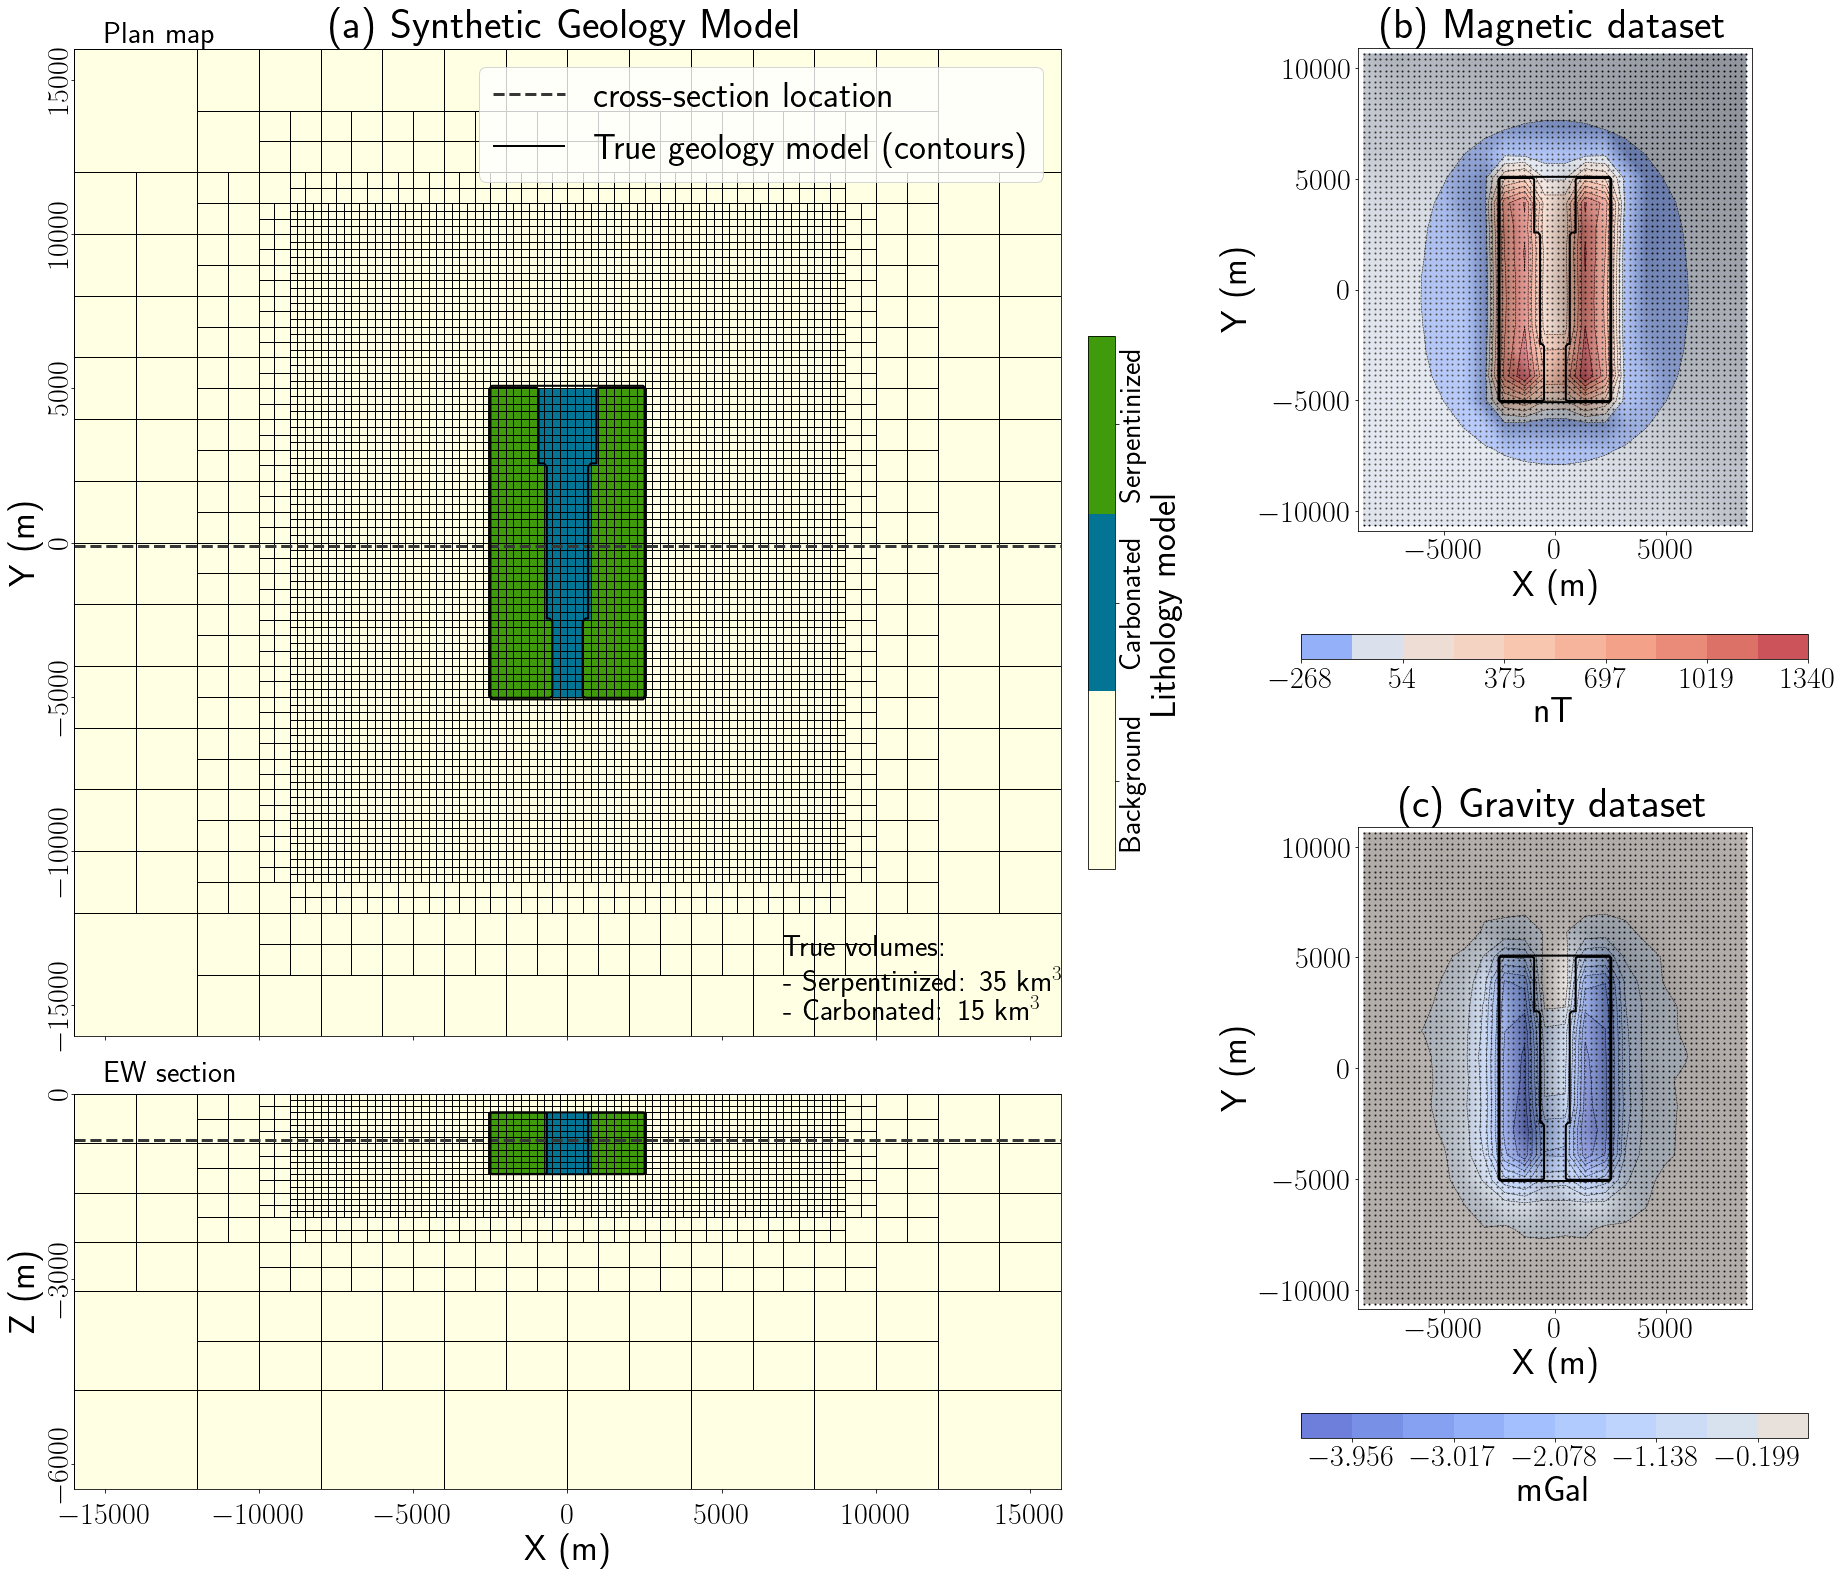

In [15]:
titlesize = 28 * 1.5
labelsize = 24 * 1.5
ticksize = 20 * 1.5

fig = plt.figure(figsize=(3*11,3*9))
ax0 = plt.subplot2grid((25,35),(0, 0),colspan=19,rowspan=17)
ax1 = plt.subplot2grid((25,35),(17, 0),colspan=19,rowspan=8)
ax2 = plt.subplot2grid((25,35),(0, 19),colspan=1,rowspan=19)
ax3 = plt.subplot2grid((25,35),(0, 23),colspan=10,rowspan=12)
ax4 = plt.subplot2grid((25,35),(13, 23),colspan=10,rowspan=12)
fig.subplots_adjust(hspace=1,wspace=1)
ax = [ax0,ax1,ax2]
ax, cb = plotting_model(
    ax=ax,
    mesh=mesh,
    plot_model=geology_model,
    clim=[0,2],
    cmap=geocmap,
    legend_cb='Lithology model',
    slicex=0.,
    slicey=0.,
    slicez= -750,
    plot_grid=True,
    is_geology=True,
    titlesize = titlesize,
    labelsize = labelsize,
    ticksize = ticksize,
)
#ax[0].scatter(
#    data_grav.survey.receiver_locations[:,0],
#    data_grav.survey.receiver_locations[:,1],
#    label='Data locations',c='xkcd:dark blue',s=2)
ax[0].legend(fontsize=labelsize)
ax[0].set_title('(a) Synthetic Geology Model', fontsize=titlesize)
ax[0].text(-15000,16200,'Plan map',fontdict={'fontsize':ticksize})
ax[1].text(-15000,200,'EW section',fontdict={'fontsize':ticksize})

ax[0].text(
    7000,-15500,
    "True volumes:\n- Serpentinized: {:.0f} km$^3$\n- Carbonated: {:.0f} km$^3$".format(
        1e-9 * volume_estimate_pgi(geology_model)[1],
        1e-9 * volume_estimate_pgi(geology_model)[0]
    ),
    fontdict={'fontsize':ticksize},
)

ax[1].tick_params(axis='both',pad=10)
ax[0].tick_params(axis='both',pad=10)
##################################
ax = [ax4,ax3]
#ax[0].set_xlim([-7500,7500])
#ax[1].set_xlim([-7500,7500])
#ax[0].set_ylim([-7500,7500])
#ax[1].set_ylim([-7500,7500])
ax[0].set_xlabel('X (m)', fontsize=labelsize)
ax[0].set_ylabel('Y (m)', fontsize=labelsize)
ax[1].set_xlabel('X (m)', fontsize=labelsize)
ax[1].set_ylabel('Y (m)', fontsize=labelsize)

for axx in ax:
    axx.tick_params(labelsize=ticksize)
#mesh.plotSlice(np.ones(mesh.nC),normal='Z', ind=int(-10), grid=True,pcolorOpts={'cmap':'Greys'},ax=ax[0])
mm = utils.plot2Ddata(data_grav.survey.receiver_locations, -data_grav.dobs,
                      ax=ax[0],level=True, 
                     nx=20,ny=20, dataloc=False,ncontour=10, shade=True,
                      contourOpts={'cmap':'coolwarm', 'alpha':0.8, 'norm':norm_grav_data}, 
                      levelOpts={'colors':'k','linewidths':0.5, 'linestyles':'dashed'}
                      )
ax[0].scatter(data_grav.survey.receiver_locations[:,0],data_grav.survey.receiver_locations[:,1],label='Data locations',c='k',s=1)
#ax[0].legend(fontsize=16,loc=4)
ax[0].set_aspect(1)
#ax[0].set_yticklabels([])
ax[0].set_title('(c) Gravity dataset', fontsize=titlesize)
cb = plt.colorbar(mm[0],ax=ax[0], orientation='horizontal')
cb.set_label('mGal', fontsize=labelsize)
cb.ax.tick_params(labelsize=ticksize)

#mesh.plotSlice(np.ones(mesh.nC),normal='Z', ind=int(-10), grid=True,pcolorOpts={'cmap':'Greys'},ax=ax[1])
mm = utils.plot2Ddata(data_mag.survey.receiver_locations,data_mag.dobs,
                      ax=ax[1],level=True, 
                     nx=20,ny=20, dataloc=False,ncontour=10, shade=True,
                      contourOpts={'cmap':'coolwarm', 'alpha':0.8, 'norm':norm_mag_data},
                     levelOpts={'colors':'k','linewidths':0.5, 'linestyles':'dashed'}
)
ax[1].scatter(data_mag.survey.receiver_locations[:,0],data_mag.survey.receiver_locations[:,1],label='Data locations',c='k',s=1)

ax[1].set_title('(b) Magnetic dataset', fontsize=titlesize)
cb = plt.colorbar(mm[0],ax=ax[1], orientation='horizontal')
cb.set_label('nT', fontsize=labelsize)
cb.ax.tick_params(labelsize=ticksize)


#overlay true geology model for comparison
indz = -9
indslicezplot = mesh.gridCC[:,2] == mesh.vectorCCz[indz]
for i in range(2):
    _, _, CS = utils.plot2Ddata(
            mesh.gridCC[indslicezplot][:,[0,1]],geology_model[indslicezplot],
            nx=200,ny=200,
             contourOpts={'alpha':0},
             clim=[0,2],
             ax=ax[i],
             level=True,
             ncontour=2,
             levelOpts={'colors':'k','linewidths':2,#'linestyles':'dotted',
            },
            method='nearest'
    )
    CS.collections[0].set_label('True geology outline')
    #ax[i].legend(fontsize=16,loc=4)
    ax[i].set_aspect(1)
plt.show()



In [16]:
fig.savefig('synthetic-three-blocks-model.png', dpi=100,bbox_inches='tight', pad_inches=0.1)

# L2

## Gravity

In [17]:
maxden = np.r_[gravity_l22+2.9,gravity_lpq+2.9,gravity_pgi+2.9,gravity_jnt+2.9].max()
minden = np.r_[gravity_l22+2.9,gravity_lpq+2.9,gravity_pgi+2.9,gravity_jnt+2.9].min()
norm_grav_model = cm.TwoSlopeNorm(vmax=maxden, vcenter=2.9, vmin=minden)

In [18]:
titlesize = 26
labelsize = 24
ticksize = 22

plotting_dict_gravity_l2 = {
    'mesh':mesh,
    'plot_model':gravity_l22+2.9,
    'clim':None,
    'cmap':'seismic',
    'legend_cb':'Density (g/cc)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'plot_cb':True,
    'title':'(a) gravity inversion $\ell_2$',
    'meshplotOpts':{'norm':norm_grav_model},
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

plotting_dict_gravity_lpq = {
    "mesh":mesh,
    "plot_model":gravity_lpq+2.9,
    "clim":None,
    "cmap":'seismic',
    "legend_cb":'Density (g/cc)',
    "slicex":0.,
    "slicey":0.,
    "slicez": -750,
    "plot_grid":False,
    'plot_cb':False,
    'title':'(c) gravity inversion $\ell_{01}$',
    'meshplotOpts':{'norm':norm_grav_model},
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

In [19]:
def plot_histogram(ax,model,title,xlabel, ylim, xlim, labelsize, ticksize, titlesize, **kwargs):

    ax.hist(model, edgecolor='k',bins=100,density=True, **kwargs);
    ax.set_xlabel(xlabel, fontsize=labelsize)

    ax.set_ylabel('Probability density', fontsize=labelsize)

    ax.set_xlim(xlim)

    ax.set_ylim(ylim)

    ax.tick_params(labelsize=ticksize)

    ax.set_title(title, fontsize=titlesize)

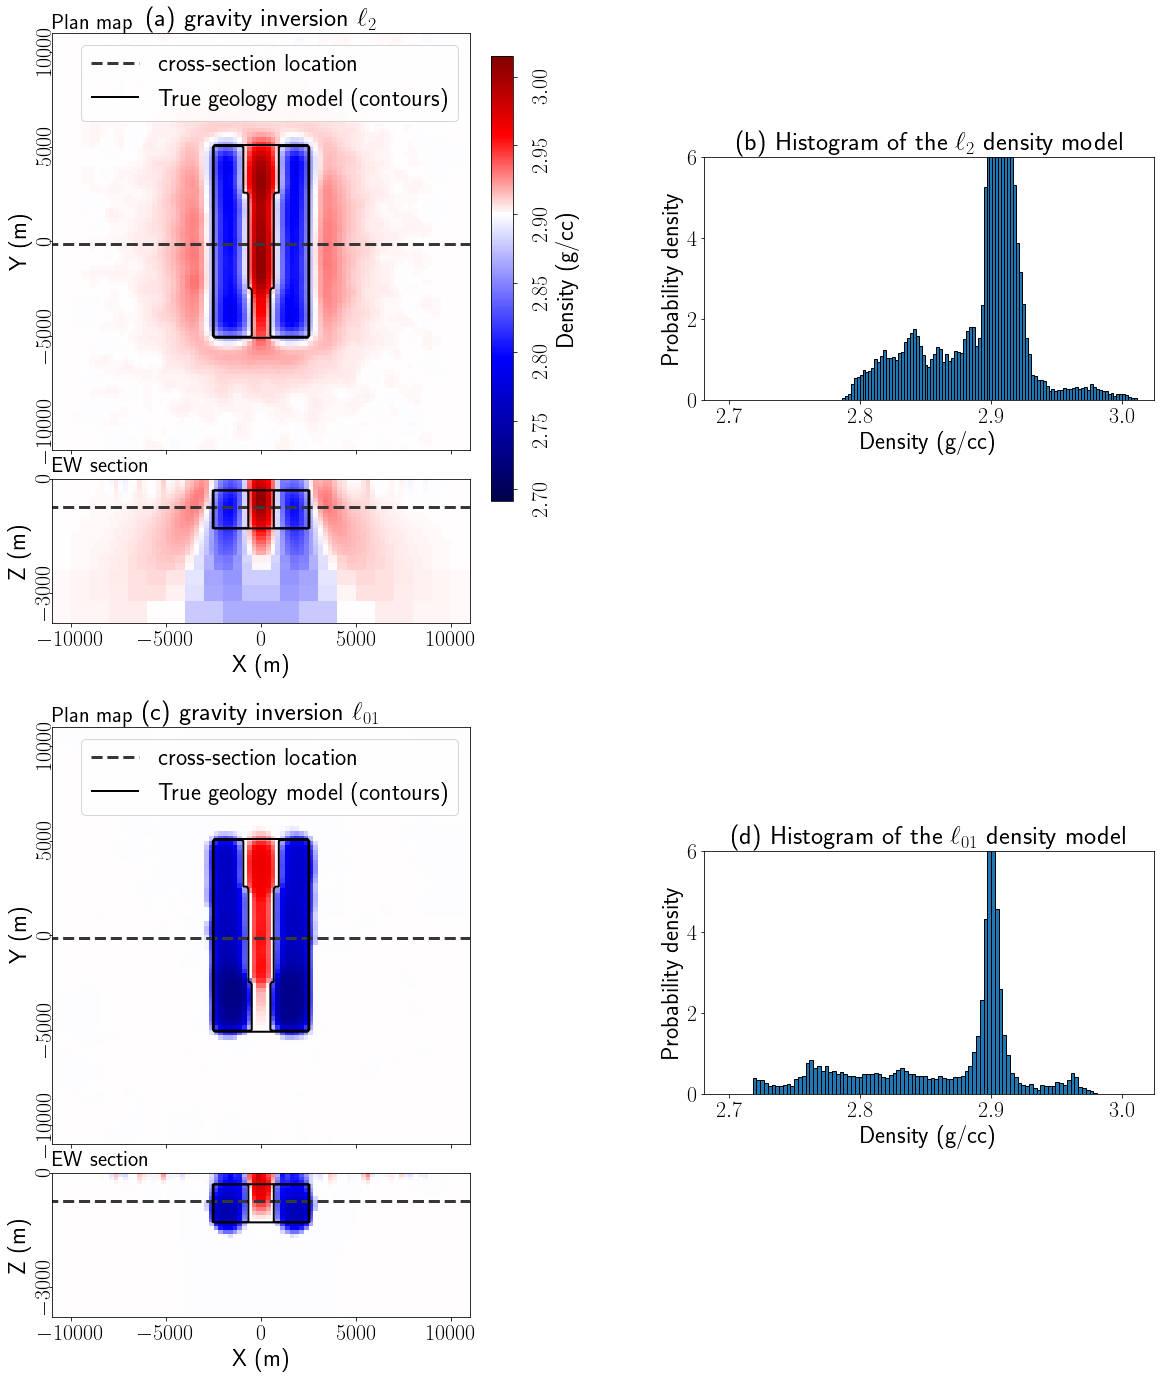

In [20]:
fig = plt.figure(figsize=(21,25))
ax_l22_0 = plt.subplot2grid((55,44,),(0, 0),colspan=17,rowspan=17)
ax_l22_1 = plt.subplot2grid((55,44,),(18, 0),colspan=17,rowspan=6)
ax_l22_2 = plt.subplot2grid((55,44,),(0, 17),colspan=1,rowspan=20)
ax_l22 = [ax_l22_0,ax_l22_1,ax_l22_2]

ax_lpq_0 = plt.subplot2grid((55,44,),(28, 0),colspan=17,rowspan=17)
ax_lpq_1 = plt.subplot2grid((55,44,),(46, 0),colspan=17,rowspan=6)
ax_lpq_2 = plt.subplot2grid((55,44,),(28, 17),colspan=1,rowspan=20)
ax_lpq = [ax_lpq_0,ax_lpq_1,ax_lpq_2]

ax_hist_l22 = plt.subplot2grid((55,44,),(5, 25),colspan=17,rowspan=10)

ax_hist_lpq = plt.subplot2grid((55,44,),(33, 25),colspan=17,rowspan=10)


for i, (dct,axx) in enumerate(zip(
    [
        plotting_dict_gravity_l2, plotting_dict_gravity_lpq, 
    ],
    [ax_l22,ax_lpq]
)):
    plotting_model(
        ax=axx,
        **dct
    )
    
ax_l22_0.set_xlim([-11000,11000])
ax_l22_0.set_ylim([-11000,11000])

ax_l22_1.set_xlim([-11000,11000])
ax_l22_1.set_ylim([-3800,0])

ax_lpq_0.set_xlim([-11000,11000])
ax_lpq_0.set_ylim([-11000,11000])

ax_lpq_1.set_xlim([-11000,11000])
ax_lpq_1.set_ylim([-3800,0])

ax_l22_0.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax_l22_1.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

ax_lpq_0.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax_lpq_1.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

plot_histogram(
    ax=ax_hist_l22,
    model=gravity_l22+2.9,
    title='(b) Histogram of the $\ell_2$ density model',
    xlabel='Density (g/cc)',
    ylim=[0,6],
    xlim=[minden-0.01,maxden+0.01],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize
)

plot_histogram(
    ax=ax_hist_lpq,
    model=gravity_lpq+2.9,
    title='(d) Histogram of the $\ell_{01}$ density model',
    xlabel='Density (g/cc)',
    ylim=[0,6],
    xlim=[minden-0.01,maxden+0.01],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize
)

In [21]:
fig.savefig('gravity_l22_lpq.png', dpi=200,bbox_inches='tight', pad_inches=0.1)

## Magnetic

In [22]:
titlesize = 26
labelsize = 24
ticksize = 22

maxsus = 0.2
minsus = 0.

plotting_dict_magnetic_l2 = {
    'mesh':mesh,
    'plot_model':magnetic_l22,
    'clim':np.r_[minsus,maxsus],
    'cmap':'Reds',
    'legend_cb':'Magnetic susceptibility (SI)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'plot_cb':True,
    'title':'(a) Magnetic inversion $\ell_{2}$',
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

plotting_dict_magnetic_lpq = {
    'mesh':mesh,
    'plot_model':magnetic_lpq,
    'clim':np.r_[minsus,maxsus],
    'cmap':'Reds',
    'legend_cb':'Magnetic susceptibility (SI)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'plot_cb':False,
    'title':'(c) Magnetic inversion $\ell_{01}$',
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

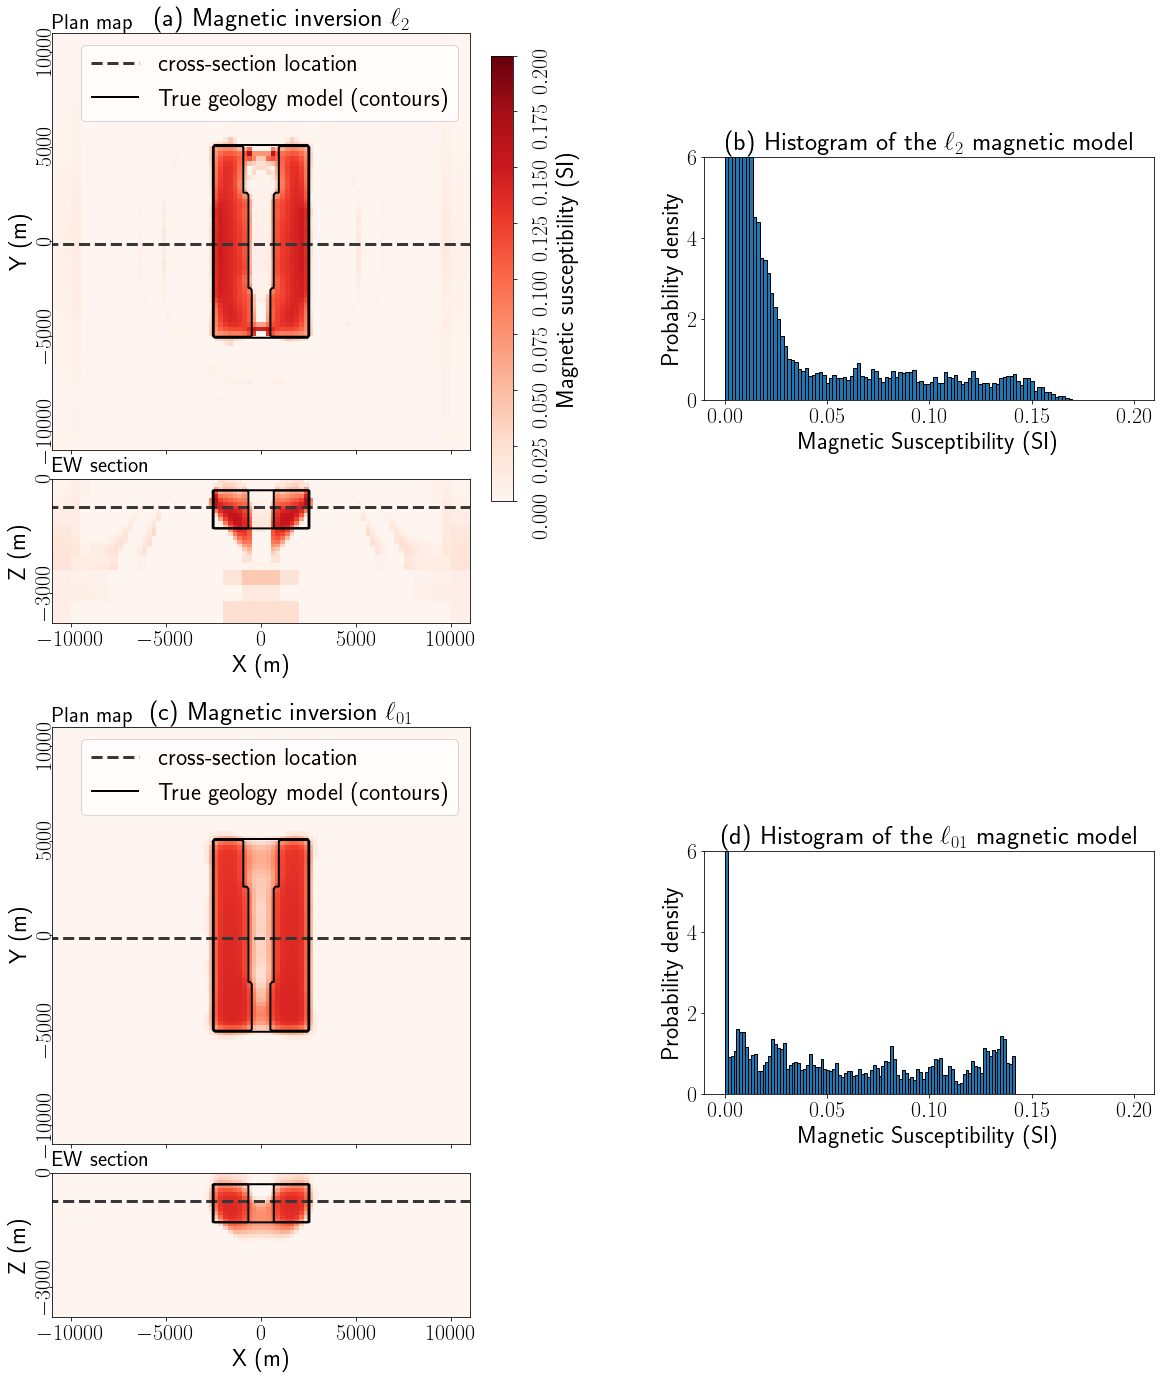

In [23]:
fig = plt.figure(figsize=(21,25))
ax_l22_0 = plt.subplot2grid((55,44,),(0, 0),colspan=17,rowspan=17)
ax_l22_1 = plt.subplot2grid((55,44,),(18, 0),colspan=17,rowspan=6)
ax_l22_2 = plt.subplot2grid((55,44,),(0, 17),colspan=1,rowspan=20)
ax_l22 = [ax_l22_0,ax_l22_1,ax_l22_2]

ax_lpq_0 = plt.subplot2grid((55,44,),(28, 0),colspan=17,rowspan=17)
ax_lpq_1 = plt.subplot2grid((55,44,),(46, 0),colspan=17,rowspan=6)
ax_lpq_2 = plt.subplot2grid((55,44,),(28, 17),colspan=1,rowspan=20)
ax_lpq = [ax_lpq_0,ax_lpq_1,ax_lpq_2]

ax_hist_l22 = plt.subplot2grid((55,44,),(5, 25),colspan=17,rowspan=10)

ax_hist_lpq = plt.subplot2grid((55,44,),(33, 25),colspan=17,rowspan=10)


for i, (dct,axx) in enumerate(zip(
    [
        plotting_dict_magnetic_l2, plotting_dict_magnetic_lpq, 
    ],
    [ax_l22,ax_lpq]
)):
    plotting_model(
        ax=axx,
        **dct
    )
    
ax_l22_0.set_xlim([-11000,11000])
ax_l22_0.set_ylim([-11000,11000])

ax_l22_1.set_xlim([-11000,11000])
ax_l22_1.set_ylim([-3800,0])

ax_lpq_0.set_xlim([-11000,11000])
ax_lpq_0.set_ylim([-11000,11000])

ax_lpq_1.set_xlim([-11000,11000])
ax_lpq_1.set_ylim([-3800,0])

ax_l22_0.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax_l22_1.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

ax_lpq_0.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax_lpq_1.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

ax_l22_0.set_title('(a) Magnetic inversion $\ell_{2}$',x=0.55,fontsize=titlesize)
ax_lpq_0.set_title('(c) Magnetic inversion $\ell_{01}$',x=0.55,fontsize=titlesize)

plot_histogram(
    ax=ax_hist_l22,
    model=magnetic_l22,
    title='(b) Histogram of the $\ell_{2}$ magnetic model',
    xlabel='Magnetic Susceptibility (SI)',
    ylim=[0,6],
    xlim=np.r_[minsus-0.01,maxsus+0.01],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize
)

plot_histogram(
    ax=ax_hist_lpq,
    model=magnetic_lpq,
    title='(d) Histogram of the $\ell_{01}$ magnetic model',
    xlabel='Magnetic Susceptibility (SI)',
    ylim=[0,6],
    xlim=np.r_[minsus-0.01,maxsus+0.01],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize
)

In [24]:
fig.savefig('magnetic_l22_lpq.png', dpi=200,bbox_inches='tight', pad_inches=0.1)

# PGI

In [25]:
titlesize = 24
labelsize=18
ticksize=20

plotting_dict_gravity_pgi = {
    'mesh':mesh,
    'plot_model':gravity_pgi+2.9,
    'clim':None,
    'cmap':'seismic',
    'legend_cb':'Density (g/cc)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'plot_cb':True,
    'title':'(d) Gravity PGI\n',
    'meshplotOpts':{'norm':norm_grav_model},
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

plotting_dict_gravity_pgi_quasi = {
    'mesh':mesh,
    'plot_model':quasi_geology_gravity,
    'clim':[0,2],
    'cmap':geocmap,
    'legend_cb':'Quasi-Geology model',
    'is_geology':True,
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'plot_cb':True,
    'title':'(e) Quasi-Geology Model from gravity PGI\n',
    #'meshplotOpts':{'norm':norm_grav_model},
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}


plotting_dict_magnetic_pgi = {
    'mesh':mesh,
    'plot_model':magnetic_pgi,
    'clim':[minsus,maxsus],
    'cmap':'Reds',
    'legend_cb':'Magnetic susceptibility (SI)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'plot_cb':True,
    'title':'(a) Magnetic PGI\n',
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

plotting_dict_magnetic_pgi_quasi = {
    'mesh':mesh,
    'plot_model':quasi_geology_magnetic,
    'clim':[0,2],
    'cmap':geocmap,
    'legend_cb':'Quasi-Geology model',
    'is_geology':True,
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'plot_cb':False,
    'title':'(b) Quasi-Geology Model from magnetic PGI\n',
    #'meshplotOpts':{'norm':norm_grav_model},
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}


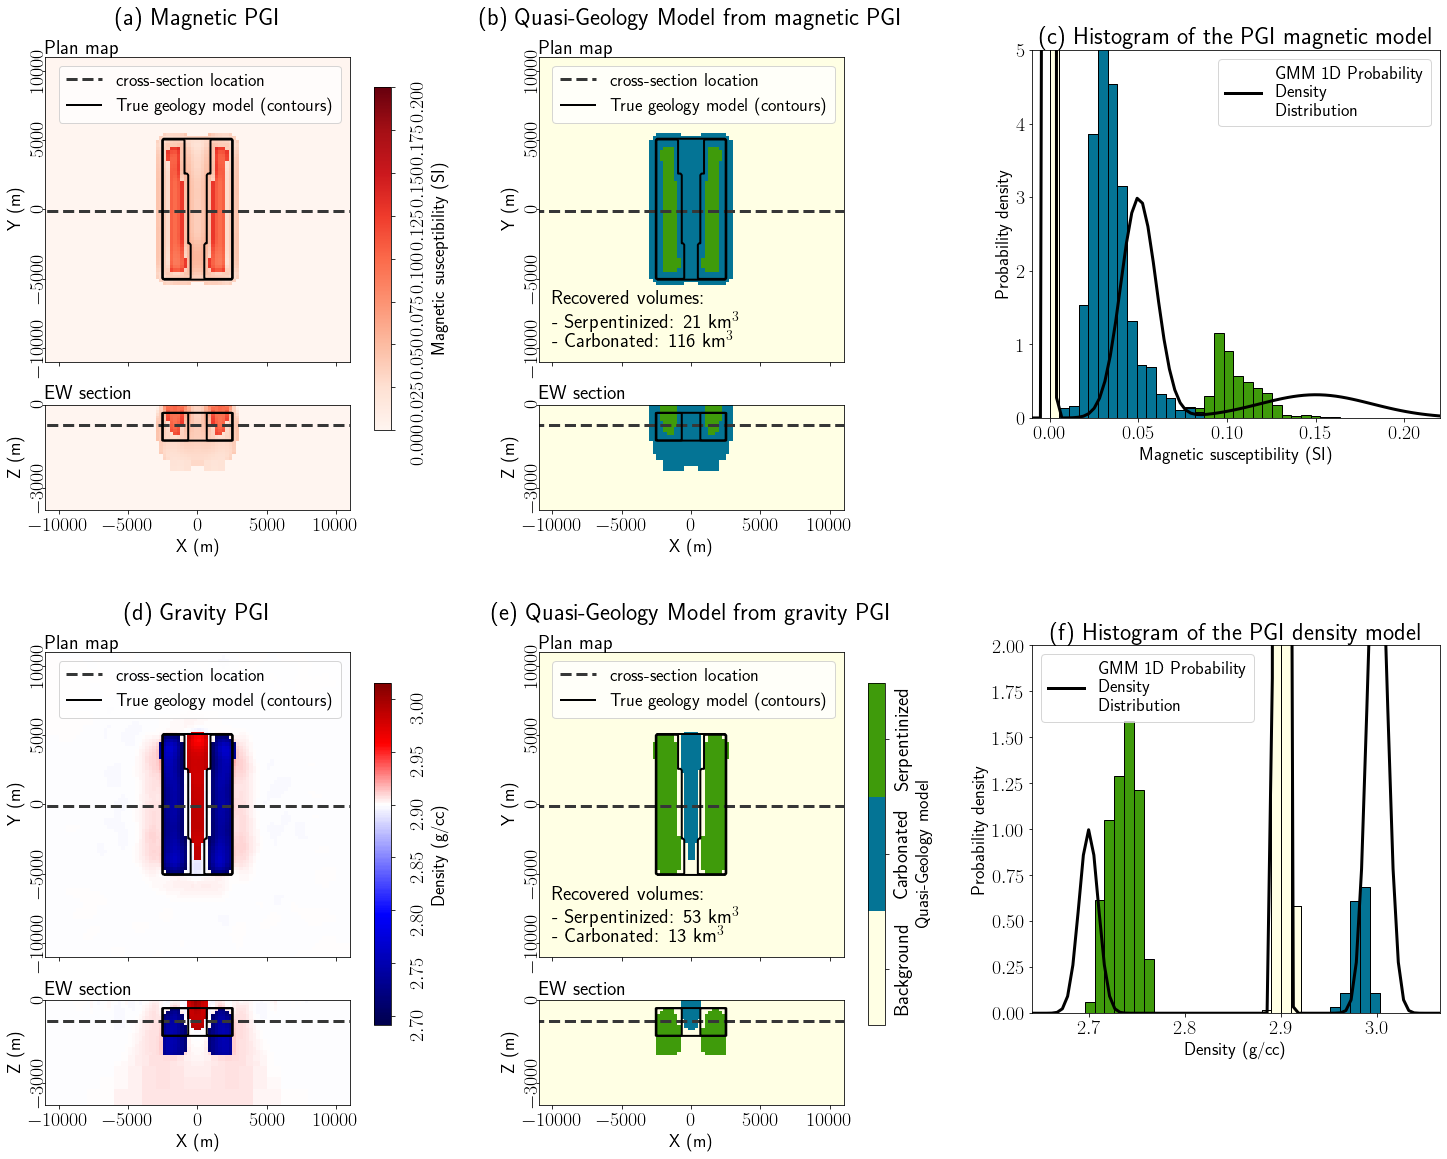

In [26]:

xsize = 20
ysize = 20
space = 4

fig = plt.figure(figsize=(25,20))

####DENSITY
ax0_mag = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(0, 0),colspan=15,rowspan=15)
ax1_mag = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(15, 0),colspan=15,rowspan=5)
ax2_mag = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(0, 16),colspan=1,rowspan=19)
ax_mag = [ax0_mag,ax1_mag,ax2_mag]

ax0_mag_geo = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(0, xsize+space+0),colspan=15,rowspan=15)
ax1_mag_geo = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(15, xsize+space+0),colspan=15,rowspan=5)
ax2_mag_geo = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(0, xsize+space+16),colspan=1,rowspan=19)
ax_mag_geo = [ax0_mag_geo,ax1_mag_geo,ax2_mag_geo]

ax_mag_hist = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(1, 2*(xsize+space)),colspan=20,rowspan=15)

ax0_grav = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(1*(ysize+space) + 0, 0),colspan=15,rowspan=15)
ax1_grav = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(1*(ysize+space) + 15, 0),colspan=15,rowspan=5)
ax2_grav = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(1*(ysize+space) + 0, 16),colspan=1,rowspan=19)
ax_grav = [ax0_grav,ax1_grav,ax2_grav]

ax0_grav_geo = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(1*(ysize+space)+0, xsize+space+0),colspan=15,rowspan=15)
ax1_grav_geo = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(1*(ysize+space)+15, xsize+space+0),colspan=15,rowspan=5)
ax2_grav_geo = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(1*(ysize+space)+0, xsize+space+16),colspan=1,rowspan=19)
ax_grav_geo = [ax0_grav_geo,ax1_grav_geo,ax2_grav_geo]

ax_grav_hist = plt.subplot2grid((2*ysize + 1*space, 3*xsize + 2*space),(1+(ysize+space), 2*(xsize+space)),colspan=20,rowspan=15)

for i, (dct,axx) in enumerate(zip(
    [
        plotting_dict_gravity_pgi, plotting_dict_gravity_pgi_quasi,
        plotting_dict_magnetic_pgi, plotting_dict_magnetic_pgi_quasi,  
    ],
    [ax_grav,ax_grav_geo,ax_mag,ax_mag_geo]
)):
    plotting_model(
        ax=axx,
        **dct
    )
    
ax0_grav.set_xlim([-11000,11000])
ax0_grav.set_ylim([-11000,11000])

ax1_grav.set_xlim([-11000,11000])
ax1_grav.set_ylim([-3800,0])

ax0_grav_geo.set_xlim([-11000,11000])
ax0_grav_geo.set_ylim([-11000,11000])

ax1_grav_geo.set_xlim([-11000,11000])
ax1_grav_geo.set_ylim([-3800,0])

ax0_mag.set_xlim([-11000,11000])
ax0_mag.set_ylim([-11000,11000])

ax1_mag.set_xlim([-11000,11000])
ax1_mag.set_ylim([-3800,0])

ax0_mag_geo.set_xlim([-11000,11000])
ax0_mag_geo.set_ylim([-11000,11000])

ax1_mag_geo.set_xlim([-11000,11000])
ax1_mag_geo.set_ylim([-3800,0])

ax0_grav.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax1_grav.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

ax0_mag.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax1_mag.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

ax0_grav_geo.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax1_grav_geo.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

ax0_grav_geo.text(
    -10000,
    -10000,
    "Recovered volumes:\n- Serpentinized: {:.0f} km$^3$\n- Carbonated: {:.0f} km$^3$".format(
        1e-9 * volume_estimate_pgi(quasi_geology_gravity)[1],
        1e-9 * volume_estimate_pgi(quasi_geology_gravity)[0]
    ),
    fontdict={'fontsize':ticksize}
)


#ax0_grav_geo.text(
#    -11000,
#    -11000,
#    'Serpentinized mass: {:.2f} $t$'.format(1e-6*mass_estimate_pgi(2.9 + gravity_pgi, quasi_geology_gravity)[1]),
#    fontdict={'fontsize':ticksize}
#)

ax0_mag_geo.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax1_mag_geo.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})
    
ax0_mag_geo.text(
    -10000,
    -10000,
    "Recovered volumes:\n- Serpentinized: {:.0f} km$^3$\n- Carbonated: {:.0f} km$^3$".format(
        1e-9 * volume_estimate_pgi(quasi_geology_magnetic)[1],
        1e-9 * volume_estimate_pgi(quasi_geology_magnetic)[0]
    ),
    fontdict={'fontsize':ticksize}
)

gmm_gravity.plot_pdf(ax=[ax_grav_hist],padding=0.4)
gmm_magnetic.plot_pdf(ax=[ax_mag_hist],padding=0.5)

plot_histogram(
    ax=ax_grav_hist,
    model=gravity_pgi+2.9,
    title='(f) Histogram of the PGI density model',
    xlabel='Density (g/cc)',
    ylim=[0,2],
    xlim=[minden-0.05,maxden+0.05],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize,
    alpha=0
)

plot_histogram(
    ax=ax_mag_hist,
    model=magnetic_pgi,
    title='(c) Histogram of the PGI magnetic model',
    xlabel='Magnetic susceptibility (SI)',
    ylim=[0,5],
    xlim=[minsus-0.01,0.22],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize,
    alpha=0
)

ax_grav_hist.hist(
    [(2.9+gravity_pgi)[quasi_geology_gravity == i] for i in np.unique(quasi_geology_gravity)], 
    density=True,bins=30,stacked=True,#orientation="horizontal",
    color=colors, edgecolor='k'
);
ax_grav_hist.legend(fontsize=labelsize)

ax_mag_hist.hist(
    [(magnetic_pgi)[quasi_geology_magnetic == i] for i in np.unique(quasi_geology_magnetic)], 
    density=True,bins=30,stacked=True,#orientation="horizontal",
    color=colors, edgecolor='k'
);
ax_mag_hist.legend(fontsize=labelsize)

In [27]:
fig.savefig('Single-Physics-PGI.png', dpi=200,bbox_inches='tight', pad_inches=0.1)

# PGI JOINT

In [28]:
titlesize = 24
labelsize=22
ticksize=18

plotting_dict_gravity_joint = {
    'mesh':mesh,
    'plot_model':gravity_jnt+2.9,
    'clim':None,
    'cmap':'seismic',
    'legend_cb':'Density (g/cc)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'plot_cb':True,
    'title':'(b) Joint PGI result:\ndensity model',
    'meshplotOpts':{'norm':norm_grav_model},
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
    
}

plotting_dict_magnetic_joint = {
    'mesh':mesh,
    'plot_model':magnetic_jnt,
    'clim':np.r_[0.,0.2],
    'cmap':'Reds',
    'legend_cb':'Magnetic susceptibility (SI)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'title':'(a) Joint PGI result:\nmagnetic susceptibility model',
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

plotting_dict_quasigeology_joint = {
    'mesh':mesh,
    'plot_model':quasi_geology_jnt,
    'clim':np.r_[0.,2],
    'cmap':geocmap,
    'legend_cb':'Quasi-Geology Model',
    'is_geology':True,
    'slicex':0.,
    'slicey':0.,
    'slicez': -750,
    'plot_grid':False,
    'title':'(d) Joint PGI result:\nQuasi-Geology Model',
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

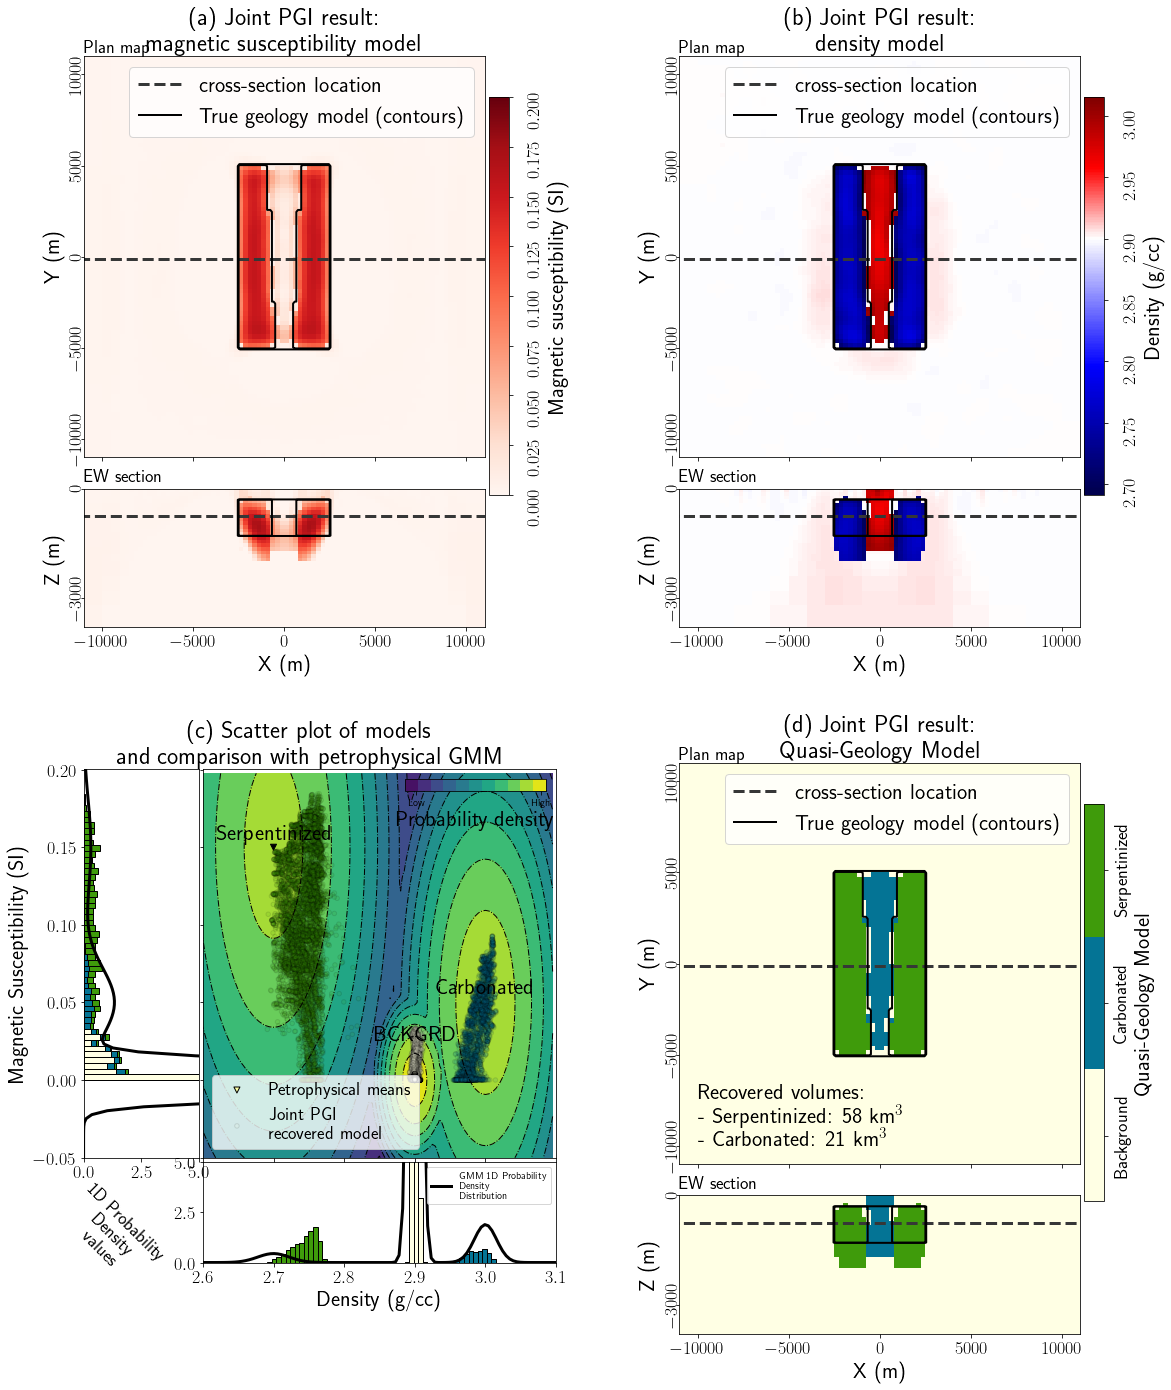

In [30]:
fig = plt.figure(figsize=(20,24))

ax_mag0 = plt.subplot2grid((50,47,),(0, 0),colspan=17,rowspan=17)
ax_mag1 = plt.subplot2grid((50,47,),(17, 0),colspan=17,rowspan=6)
ax_mag2 = plt.subplot2grid((50,47,),(0, 17),colspan=1,rowspan=20)
ax_mag = [ax_mag0,ax_mag1,ax_mag2]

ax_grav0 = plt.subplot2grid((50,47,),(0, 25),colspan=17,rowspan=17)
ax_grav1 = plt.subplot2grid((50,47,),(17, 25),colspan=17,rowspan=6)
ax_grav2 = plt.subplot2grid((50,47,),(0, 42),colspan=1,rowspan=20)
ax_grav = [ax_grav0,ax_grav1,ax_grav2]

ax_geo0 = plt.subplot2grid((50,47,),(27, 25),colspan=17,rowspan=17)
ax_geo1 = plt.subplot2grid((50,47,),(44, 25),colspan=17,rowspan=6)
ax_geo2 = plt.subplot2grid((50,47,),(27, 42),colspan=1,rowspan=20)
ax_geo = [ax_geo0,ax_geo1,ax_geo2]

# Plot GMM
ax0 = plt.subplot2grid((50,47), (43,5), colspan=15,rowspan=4)
ax1 = plt.subplot2grid((50,47), (28,5), colspan=15, rowspan=15)
ax2 = plt.subplot2grid((50,47), (28, 0), rowspan=15,colspan=5)

#Plot model
for i, (dct,axx) in enumerate(zip(
    [
        plotting_dict_gravity_joint,
        plotting_dict_magnetic_joint,
        plotting_dict_quasigeology_joint,
    ],
    [ax_grav,ax_mag,ax_geo]
)):
    plotting_model(
        ax=axx,
        **dct
    )

for axx in [ax_grav,ax_mag,ax_geo]:
    axx[0].set_xlim([-11000,11000])
    axx[0].set_ylim([-11000,11000])
    
    axx[1].set_xlim([-11000,11000])
    axx[1].set_ylim([-3800,0])
    
    axx[0].text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
    axx[1].text(-11000,200,'EW section',fontdict={'fontsize':ticksize})
    
    
ax_geo0.text(
    -10000,
    -10000,
    "Recovered volumes:\n- Serpentinized: {:.0f} km$^3$\n- Carbonated: {:.0f} km$^3$".format(
        1e-9 * volume_estimate_pgi(quasi_geology_jnt)[1],
        1e-9 * volume_estimate_pgi(quasi_geology_jnt)[0]
    ),fontdict={'fontsize':labelsize}
)

#ax_geo0.text(
#    -10000,
#    -10000,
#    'Serpentinized mass: {:.2f} $t$'.format(1e-6 * mass_estimate_pgi(2.9 + gravity_jnt, quasi_geology_jnt)[1]),
#    fontdict={'fontsize':labelsize}
#)

[ax0,ax1,ax2], cb2d = gmm_joint.plot_pdf(ax=[ax0,ax1,ax2],flag2d=True, padding=0.334)

cb2d.set_label('Probability density',fontsize=labelsize)

# all panels
for axx in [ax0,ax1,ax2]:
    axx.tick_params(labelsize=ticksize)

# details of 2D panel
ax1.text(2.7,0.155, 'Serpentinized', fontsize=labelsize, ha='center')
ax1.text(3.0,0.055, 'Carbonated', fontsize=labelsize, ha='center')
ax1.text(2.9, 0.025, 'BCKGRD', fontsize=labelsize, ha='center')#, color='white')
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax1.set_title(
    '(c) Scatter plot of models\nand comparison with petrophysical GMM'
    , fontsize=titlesize, x=0.3
)
ax1.scatter(
    2.9+gravity_jnt, magnetic_jnt,
    c=quasi_geology_jnt,cmap=geocmap,
    s=20,alpha=0.1,edgecolors='k', label='Joint PGI\nrecovered model'
)
ax1.legend(fontsize=18,loc=3)

# details of side panels
ax0.hist(
    [2.9+gravity_jnt[quasi_geology_jnt==i] for i in range(3)], 
    density=True,bins=50,stacked=True, color=colors, edgecolor='k'
)
ax0.set_ylim([0,5])
ax0.set_xlabel('Density (g/cc)', fontsize=labelsize)
ax0.set_ylabel('')

ax2.hist(
    [magnetic_jnt[quasi_geology_jnt==i] for i in range(3)], 
    density=True,bins=50,orientation="horizontal",stacked=True,
    color=colors, edgecolor='k'
)
ax2.set_xlim([0,5])
ax2.set_xlabel('1D Probability\nDensity\nvalues',fontsize=18, 
               rotation=-45, labelpad=0,x=0.25)
ax2.set_ylabel('Magnetic Susceptibility (SI)', fontsize=labelsize)
ax2.get_legend().remove()

plt.show()

In [31]:
fig.savefig('joint-PGI.png', dpi=150,bbox_inches='tight', pad_inches=0.1)

# Plot GMM

ValueError: not enough values to unpack (expected 3, got 2)

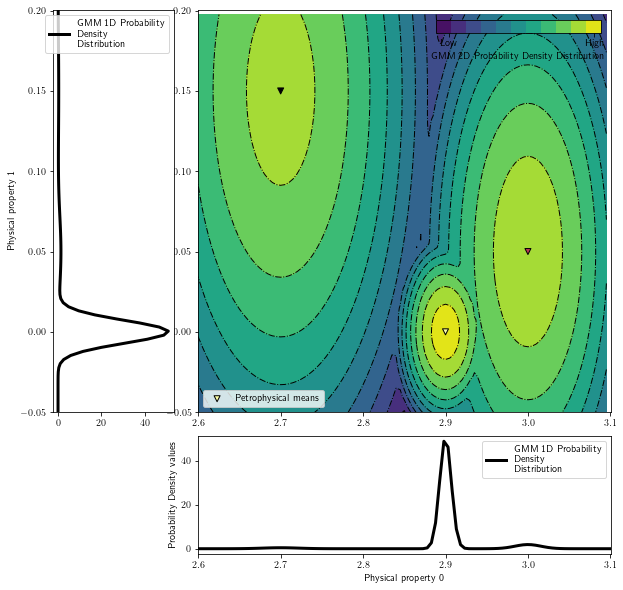

In [32]:
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((4, 4), (3, 1), colspan=3)
ax1 = plt.subplot2grid((4, 4), (0, 1), colspan=3, rowspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3)# Plot GMM
[ax0,ax1,ax2] = gmm_joint.plot_pdf(ax=[ax0,ax1,ax2],flag2d=True, padding=0.334)

# all panels
for axx in [ax0,ax1,ax2]:
    axx.tick_params(labelsize=ticksize)

# details of 2D panel
ax1.text(2.7,0.155, 'Serpentinized', fontsize=labelsize, ha='center')
ax1.text(3.0,0.055, 'Carbonated', fontsize=labelsize, ha='center')
ax1.text(2.9, 0.025, 'BCKGRD', fontsize=labelsize, ha='center')#, color='white')
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax0.set_ylim([0,5])
ax0.set_xlabel('Density (g/cc)', fontsize=labelsize)
ax0.set_ylabel('')

ax2.set_xlim([0,5])
ax2.set_xlabel('1D Probability\nDensity\nvalues',fontsize=18, 
               rotation=-45, labelpad=0,x=0.25)
ax2.set_ylabel('Magnetic Susceptibility (SI)', fontsize=labelsize)
ax2.get_legend().remove()

plt.show()

In [ ]:
fig.savefig('synthetic-GMM.png', dpi=150,bbox_inches='tight', pad_inches=0.1)